# Group 3 Lunar Landing Solution with Actor Critic (ADP) architecture

In [ ]:
## Installs for Colab:
#
!pip install swig
!pip install pocketsphinx
!pip install gymnasium
!pip install torch

In [15]:
## Imports:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator

import gymnasium as gym
#   To save the ouput of the renders to an mp4 file:
# from gym import wrappers
# from gym.wrappers import Monitor

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical



### Hyperparameters used in the experiment:

In [7]:
N_EPISODES       = 400

ACTOR_LR         = 0.0005 #0.00005
A_LAYER1_OUTPUTS = 512      # 64
A_LAYER2_OUTPUTS = 256      # 64

CRITIC_LR        = 0.0005
C_LAYER1_OUTPUTS = 512      # 64
C_LAYER2_OUTPUTS = 256      # 64

GAMMA            = 0.9      # 0.99

### Neural Network design

    Actor NN:
        Linear (8, 64)              A_LAYER1_OUTPUTS = 512
        Linear (64, 64)             A_LAYER2_OUTPUTS = 256
        Linear (64, 4)
        Learning Rate:              0.00005

    Critic NN:
        Linear (8, 64)              C_LAYER1_OUTPUTS = 256
        Linear (64, 64)             C_LAYER1_OUTPUTS = 64
        Linear (64, 1)
        Learning Rate:              0.0001

### Lunar Lander Rewards and Environment Settings

- Reward for moving from the top of the screen to the landing pad and coming to rest: 100 - 140 pts
- If the lander moves away from the landing pad, it loses reward
- If the lander crashes, it receives an additional -100 points
- If it comes to rest, it receives an additional +100 points.
- Each leg with ground contact is +10 points
- Firing the main engine is -0.3 points each frame
- Firing the side engine is -0.03 points each frame
- Solved is 200 points

### Episode Termination:
- the lander crashes (the lander body gets in contact with the moon)
- the lander gets outside of the viewport (x coordinate is greater than 1)

In [ ]:
REST_REWARD      = 100
SOLVED           = 200

In [ ]:
# # set device as global:

# # _device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

# _device = 'cuda:0' if T.cuda.is_available() else 'cpu'

# print(_device)

In [8]:
## --------------------------------------------------------------------------------
## Experiment results plotting functions
#
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator

def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Running average of previous 100 scores')
    plt.show()

def plot_combined_mse(x, actor_loss, critic_loss):
    sum_loss = [elem1 + elem2 for elem1, elem2 in zip(actor_loss, critic_loss)]
    plt.plot(x, sum_loss)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Episode')
    plt.ylabel('Mean Square Error')
    plt.title('Combined Actor-Critic MSE Loss')
    plt.legend()
    plt.show()

def plot_win_loss(game_outcomes):
    accumulated_wins = [sum(game_outcomes[:i+1]) for i in range(len(game_outcomes))]
    win_rate = [a/b * 100 for a, b in zip(accumulated_wins, x)]
    title = f'Win Rate ({N_EPISODES} games)'
    plt.plot(x, win_rate)
    plt.xlabel('Episode')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.ylabel('Win %')
    plt.title(title)
    plt.show()

def plot_weights_trajectory(weights_array):
    plt.figure(figsize=(10, 6))
    # ax = plt.subplot(111)

    # Plot each row as a separate line
    for i in range(weights_array.shape[1]):  # Iterate through columns (features)
        plt.plot(weights_array[:, i], label=f'Feature {i+1}')

    # Set labels and title
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.title('Weight Trajectory by Feature')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
## --------------------------------------------------------------------------------
## Network base class
#
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)


In [10]:
## --------------------------------------------------------------------------------
## Actor network implementation
#

class ActorNetwork(BaseNetwork):
    def __init__(self, learn_rate, input_size, n_actions, fc1_size, fc2_size):
        super(ActorNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, n_actions)

        # optim.Adam initialization: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)

    def forward(self, observation):
        state = T.tensor(observation, dtype=T.float).to(self.device)
        return self.forward_relu(state)

    def forward_relu(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

    def forward_tanh(self, state):
        x = T.tanh(self.fc1(state))
        x = T.tanh(self.fc2(x))
        # transform tensor into a vector of valid probabilities that sum to 1:
        actions = F.softmax(self.fc3(x), dim=1)
        return actions


In [11]:
## --------------------------------------------------------------------------------
## Critic network implementation
#
class CriticNetwork(BaseNetwork):
    def __init__(self, learn_rate, input_size, fc1_size, fc2_size):
        super(CriticNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)

    def forward(self, observation):
        state = T.tensor(observation, dtype=T.float).to(self.device)
        return self.forward_relu(state)

    def forward_relu(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

    def forward_tanh(self, state):
        x = T.tanh(self.fc1(state))
        x = T.tanh(self.fc2(x))
        actions = F.softmax(self.fc3(x), dim=1)
        return actions


In [12]:
## --------------------------------------------------------------------------------
## Agent implementation
#
class Agent():
    def __init__(self, actor, critic, gamma) -> None:
        self.actor = actor
        self.critic = critic
        self.gamma = gamma


    def choose_action(self, observation):
        #state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        # state = T.as_tensor([observation], device=self.actor.device)

        np_state = np.array([observation])
        state = T.as_tensor(np_state, device=self.actor.device)
        log_odds = self.actor.forward(state)

        # transform tensor into a vector of valid probabilities that sum to 1
        probabilities = F.softmax(log_odds, dim=1)

        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()


    def learn(self, state, reward, state_, done):
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()

        state = T.tensor([state], dtype=T.float).to(self.actor.device)
        state_ = T.tensor([state_], dtype=T.float).to(self.actor.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)

        critic_value = self.critic.forward(state)
        critic_value_ = self.critic.forward(state_)

        # Actor-critic loss function in reinforcement learning:
        #   https://stats.stackexchange.com/questions/321234/actor-critic-loss-function-in-reinforcement-learning
        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        # The actor's loss is typically related to the log probability of the selected action multiplied by an advantage or a value function
        actor_loss = -self.log_prob*delta

        # The critic's loss is related to the difference between the estimated value and the actual (discounted) return
        critic_loss = delta**2

        # The combined loss is used to compute gradients with respect to the parameters of both the actor and critic networks
        #   (Back Propagating in PyTorch: https://www.youtube.com/watch?v=Rnk2AYiQvwY&t=72s)
        (actor_loss + critic_loss).backward()

        # Update weights: the Adam optimizer is used to update the weights of both networks based on the computed gradient
        self.actor.optimizer.step()
        self.critic.optimizer.step()

        return actor_loss, critic_loss



In [14]:
## --------------------------------------------------------------------------------
## Agent implementation
#
class Agent():
    def __init__(self, actor, critic, gamma) -> None:
        self.actor = actor
        self.critic = critic
        self.gamma = gamma


    def choose_action(self, observation):
        #state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        # state = T.as_tensor([observation], device=self.actor.device)
        np_state = np.array([observation])
        state = T.as_tensor(np_state, device=self.actor.device)
        log_odds = self.actor.forward(state)

        # transform tensor into a vector of valid probabilities that sum to 1
        probabilities = F.softmax(log_odds, dim=1)

        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob

        return action.item()


    def learn(self, state, reward, state_, done):
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()

        # state = T.tensor([state], dtype=T.float).to(self.actor.device)
        # state_ = T.tensor([state_], dtype=T.float).to(self.actor.device)
        # reward = T.tensor(reward, dtype=T.float).to(self.actor.device)

        np_state = np.array(state)
        state = T.as_tensor(np_state, device=self.actor.device)

        # state = T.as_tensor([observation], device=self.actor.device)
        np_state_ = np.array(state_)
        state_ = T.as_tensor(np_state_, device=self.actor.device)

        critic_value = self.critic.forward(state)
        critic_value_ = self.critic.forward(state_)

        # Actor-critic loss function in reinforcement learning:
        #   https://stats.stackexchange.com/questions/321234/actor-critic-loss-function-in-reinforcement-learning
        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        # The actor's loss is typically related to the log probability of the selected action multiplied by an advantage or a value function
        actor_loss = -self.log_prob*delta

        # The critic's loss is related to the difference between the estimated value and the actual (discounted) return
        critic_loss = delta**2

        # The combined loss is used to compute gradients with respect to the parameters of both the actor and critic networks
        #   (Back Propagating in PyTorch: https://www.youtube.com/watch?v=Rnk2AYiQvwY&t=72s)
        (actor_loss + critic_loss).backward()

        # Update weights: the Adam optimizer is used to update the weights of both networks based on the computed gradient
        self.actor.optimizer.step()
        self.critic.optimizer.step()

        return actor_loss, critic_loss



In [ ]:
## --------------------------------------------------------------------------------
## Main module
#

env = gym.make("LunarLander-v2", render_mode="human")

actor = ActorNetwork(learn_rate=ACTOR_LR,
                      input_size=[8],
                      n_actions=4,
                      fc1_size=A_LAYER1_OUTPUTS,
                      fc2_size=A_LAYER2_OUTPUTS)

critic = CriticNetwork(learn_rate=CRITIC_LR,
                        input_size=[8],
                        fc1_size=C_LAYER1_OUTPUTS,
                        fc2_size=C_LAYER2_OUTPUTS)

agent = Agent(actor, critic, gamma=GAMMA)

scores = []
actor_losses = []
critic_losses = []
game_outcomes = []
weights = []
wins = 0

for i in range(N_EPISODES):
    done = False

    # return type is tuple, 1st element is the 8-dimensional vector of state values
    observation = env.reset()[0]

    nSteps = 0
    score = 0
    episode_actor_loss = 0
    episode_critic_loss = 0
    while not done:
        action = agent.choose_action(observation)

        nSteps += 1
        observation_, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        score += reward
        if score >= REST_REWARD:
            done = True

        actor_loss, critic_loss = agent.learn(observation, reward, observation_, done)
        episode_actor_loss += actor_loss.item()
        episode_critic_loss += critic_loss.item()
        observation = observation_

    scores.append(score)
    actor_losses.append(episode_actor_loss)
    critic_losses.append(episode_critic_loss)

    w = agent.actor.fc3.weight.data.cpu().numpy().flatten()
    current_weight = w[:10]
    weights.append(current_weight)
    weights_array = np.vstack(weights)

    if score >= REST_REWARD:
        wins =+ 1
        game_outcomes += [1]
    else:
        game_outcomes += [0]

    avg_score = np.mean(scores[-100:])
    win_pct = wins /(i+1)
    print('Episode ', i, 'score %.1f' % score, 'average score %.1f' % avg_score, ' Steps ', nSteps, ' Win Pct %.2f' % win_pct)

    if i > 100 and win_pct > 30.0:
        break

env.close()


In [ ]:
## --------------------------------------------------------------------------------
## Post-run visualizations
#

x = [i+1 for i in range(N_EPISODES)]
plot_learning_curve(x, scores)

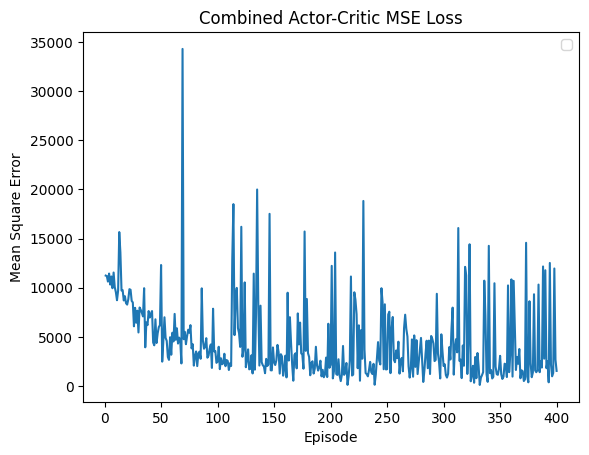

In [ ]:
plot_combined_mse(x, actor_losses, critic_losses)

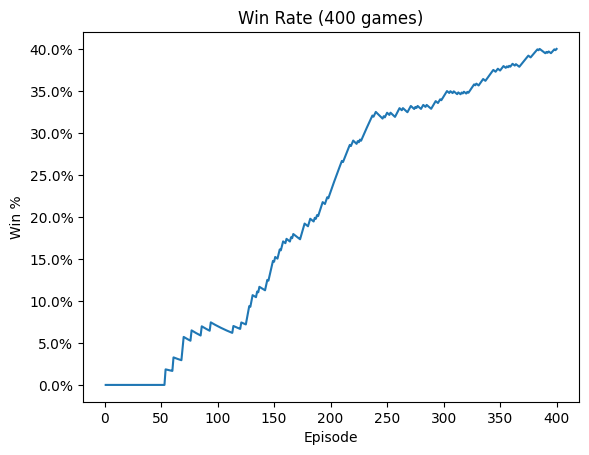

In [ ]:
plot_win_loss(game_outcomes)

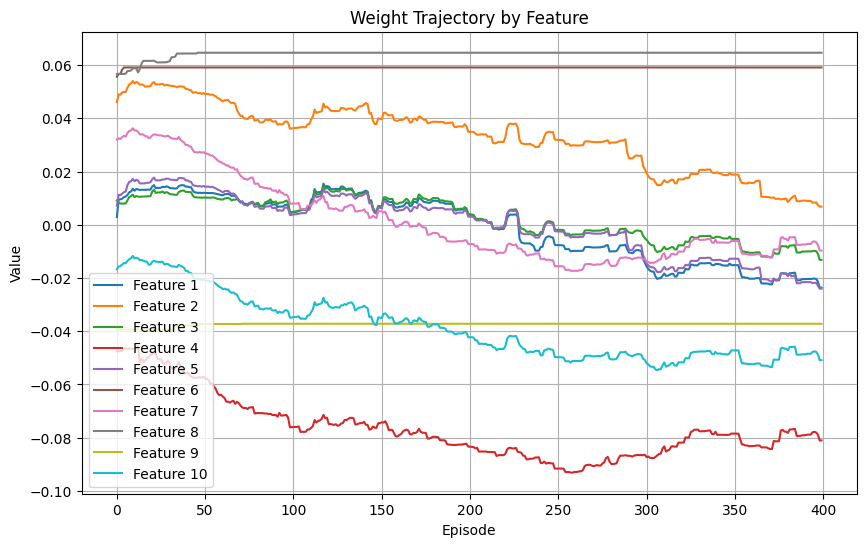

In [ ]:
plot_weights_trajectory(weights_array)